# Imports

In [517]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')

# Data Loading and Preparation

In [518]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')
submission=pd.read_csv('./gender_submission.csv')

Random_state=12
Folds=5
Strategy='median'  ## SimpleImputer 매개변수(median-중앙값, mean-평균, most_frequent-최빈값..)

## train data

In [519]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [520]:
print(f'\033[94m Number of rows in train data : {train.shape[0]}')
print(f'\033[94m Number of columns in train data : {train.shape[1]}')
print(f'\033[94m Number of values train data : {train.count().sum()}')
print(f'\033[94m Number of missing values in train data : {sum(train.isna().sum())}')

 Number of rows in train data : 891
 Number of columns in train data : 12
 Number of values train data : 9826
 Number of missing values in train data : 866


### Columns에서 누락된 값 확인

In [521]:
print(f'\033[94m ')
print(train.isnull().sum().sort_values(ascending=False))

 
Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64


### Training data 기초 통계


In [522]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.00,446.00,257.35,1.00,223.50,446.00,668.50,891.00
Survived,891.00,0.38,0.49,0.00,0.00,0.00,1.00,1.00
Pclass,891.00,2.31,0.84,1.00,2.00,3.00,3.00,3.00
Age,714.00,29.70,14.53,0.42,20.12,28.00,38.00,80.00
SibSp,891.00,0.52,1.10,0.00,0.00,0.00,1.00,8.00
Parch,891.00,0.38,0.81,0.00,0.00,0.00,0.00,6.00
Fare,891.00,32.20,49.69,0.00,7.91,14.45,31.00,512.33


## Test data 탐색
* 총 418개의 행과 11개의 열로 구성되어 있다. 
* 414개의 결측값을 포함한 4184개의 데이터로 구성되어 있다.
* 3개의 열은(Cabin, Age, Fare)는 결측값을 가지고 있으며, 그 중 **Cabin** 데이터의 결측값이 가장 많다.(327개)

In [523]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S


In [524]:
print(f'\033[94mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[94mNumber of values in test data: {test.count().sum()}')
print(f'\033[94mNumber of missing values in test data: {sum(test.isna().sum())}')

Number of rows in test data: 418
Number of columns in test data: 11
Number of values in test data: 4184
Number of missing values in test data: 414


### Columns에서 누락된 값 확인

In [525]:
print(f'\033[94m')
print(test.isnull().sum().sort_values(ascending=False))


Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64


### test 기초 통계

In [526]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.00,1100.50,120.81,892.00,996.25,1100.50,1204.75,1309.00
Pclass,418.00,2.27,0.84,1.00,1.00,3.00,3.00,3.00
Age,332.00,30.27,14.18,0.17,21.00,27.00,39.00,76.00
SibSp,418.00,0.45,0.90,0.00,0.00,0.00,1.00,8.00
Parch,418.00,0.39,0.98,0.00,0.00,0.00,0.00,9.00
Fare,417.00,35.63,55.91,0.00,7.90,14.45,31.50,512.33


## Submission File

In [527]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# EDA

## 데이터 전체보기

In [528]:
train.drop(['PassengerId'], axis=1, inplace=True)
test.drop(['PassengerId'], axis=1, inplace=True)

Target='Survived'
Features = [col for col in train.columns if col != Target]

In [529]:
train.iloc[:,1:].describe().T.sort_values(by='std', ascending=False).style.background_gradient(cmap='GnBu')\
.bar(subset=['max'], color='red').bar(subset='mean', color='green')

,count,mean,std,min,25%,50%,75%,max
Fare,891.000000,32.204208,49.693429,0.000000,7.910400,14.454200,31.000000,512.329200
Age,714.000000,29.699118,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000
SibSp,891.000000,0.523008,1.102743,0.000000,0.000000,0.000000,1.000000,8.000000
Pclass,891.000000,2.308642,0.836071,1.000000,2.000000,3.000000,3.000000,3.000000
Parch,891.000000,0.381594,0.806057,0.000000,0.000000,0.000000,0.000000,6.000000


## 결측값 분포
* 행 별 누락값중 최댓값은 2개 이며, 대부분은 1가지 값이 누락되어 있다.
* 결측값의 분포(행 기준)는 train, test set이 유사한 것을 알 수 있다.
* 약 20% 만의 관찰값은 결측값이 없다.(행 기준)
* 결측값이 1개 이상인 값은 약 78%이다. 

### row 기준 결측치 분포

In [530]:
missing_train_row=train.isna().sum(axis=1)
missing_train_row=pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()

missing_test_row=test.isna().sum(axis=1)
missing_test_row=pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()

missing_train_row.columns=['no','count']
missing_test_row.columns=['no','count']

missing_train_row['count']=missing_train_row['count']*100
missing_test_row['count']=missing_test_row['count']*100

In [531]:
fig=make_subplots(rows=1, cols=2, column_titles=['Train Data', 'Test Data'], x_title='Missing Values')

fig.add_trace(go.Bar(x=missing_train_row['no'], y=missing_train_row['count'],
              marker=dict(color=[n for n in range(6)],
                         line_color='rgb(0,0,0)',
                         line_width=3,
                         coloraxis='coloraxis')),1,1)

fig.add_trace(go.Bar(x=missing_test_row['no'], y=missing_test_row['count'],
                    marker=dict(color=[n for n in range(6)],
                               line_color='rgb(0,0,0)',
                               line_width=3,
                               coloraxis='coloraxis')),1,2)

fig.update_layout(showlegend=False, title_text='Row wise Null Value Distribution', title_x=.5)

### Column 기준 결측치 분포

In [532]:
test_null=pd.DataFrame(test.isna().sum())
test_null=test_null.sort_values(by=0, ascending=False)

train_null=pd.DataFrame(train.isna().sum()).iloc[1:]
train_null=train_null.sort_values(by=0, ascending=False)

In [533]:
fig=make_subplots(rows=1, cols=2, column_titles=['Train Data','Test Data'], x_title='Missing Values')

# train.column 표시
fig.add_trace(go.Bar(x=train_null[0], y=train_null.index, orientation='h',
                    marker=dict(color=[n for n in range(12)],
                               line_color='rgb(0,0,0)',
                               line_width=2,
                               coloraxis='coloraxis')),1,1)

# test.column 표시
fig.add_trace(go.Bar(x=test_null[0], y=test_null.index, orientation='h',
                    marker=dict(color=[n for n in range(12)],
                               line_color='rgb(0,0,0)',
                               line_width=2,
                               coloraxis='coloraxis')),1,2)

fig.update_layout(showlegend=False, title_text='Column wise Null Value Distribution', title_x=.5)

## 연속형, 범주형 자료 분포
- 총 10개 변수 중 3개는 연속형, 5개는 범주형, 2개는 문자형 데이터로 구성되어 있다.
- **PClass'**, **'Embarked'**는 3개, 4개의 고유한 값으로 구성되어 있다.
- **'Sex'** 변수는 bool 변수이다.

In [534]:
df = pd.concat([train[Features], test[Features]], axis=0)
text_features=['Name', 'Ticket',]

# 이산형 변수
cat_features = [col for col in Features if df[col].nunique() < 10 and col not in text_features]
# 연속형 변수
cont_features = [col for col in Features if df[col].nunique() >=10 and col not in text_features]

del df

In [535]:
print(f'\033[94m Total Number of Features : {len(Features)}')
print(f'\033[94m Number of categorical features : {len(cat_features)}')
print(f'\033[94m Number of continuos featuers : {len(cont_features)}')
print(f'\033[94m Number of text features {len(text_features)}')

labels=['Categorical','Continuos','Text']
values=[len(cat_features), len(cont_features), len(text_features)]
colors=['#DE3163','#58D68D']

fig=go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0.1, 0, 0],
                          marker=dict(colors=colors,
                                     line=dict(color='#000000',
                                              width=2)))])

fig.show()

 Total Number of Features : 10
 Number of categorical features : 5
 Number of continuos featuers : 3
 Number of text features 2


### 연속형 변수 분포

In [536]:
cont_features

['Age', 'Fare', 'Cabin']

**Age**

In [537]:
train_age=train.copy()
test_age=test.copy()

train_age['type']='Train'
test_age['type']='Test'

ageDF=pd.concat([train_age, test_age])

fig=px.histogram(data_frame=ageDF,
                x='Age', color='type', color_discrete_sequence=colors,
                marginal='box', nbins=100, template='plotly_white')

fig.update_layout(title='Distribution of Age', title_x=.5)
fig.show()

**Fare**

In [538]:
train_Fare=train.copy()
test_Fare=test.copy()

train_Fare['type']='Train'
test_Fare['type']='Test'

FareDF=pd.concat([train_Fare, test_Fare])

fig=px.histogram(data_frame=FareDF,
                x='Fare', color='type', color_discrete_sequence=colors,
                marginal='box', nbins=100, template='plotly_white')

fig.update_layout(title='Distribution of Fare', title_x=.5)
fig.show()

**Cabin**

In [539]:
train_Cabin=train.copy()
test_Cabin=test.copy()

train_Cabin['type']='Train'
test_Cabin['type']='Test'

CabinDF=pd.concat([train_Cabin, test_Cabin])

fig=px.histogram(data_frame=CabinDF,
                x='Cabin', color='type', color_discrete_sequence=colors,
                marginal='box', nbins=100, template='plotly_white')

fig.update_layout(title='Distribution of Cabin', title_x=.5)
fig.show()

## 범주형 변수 분포

In [540]:
cat_features

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

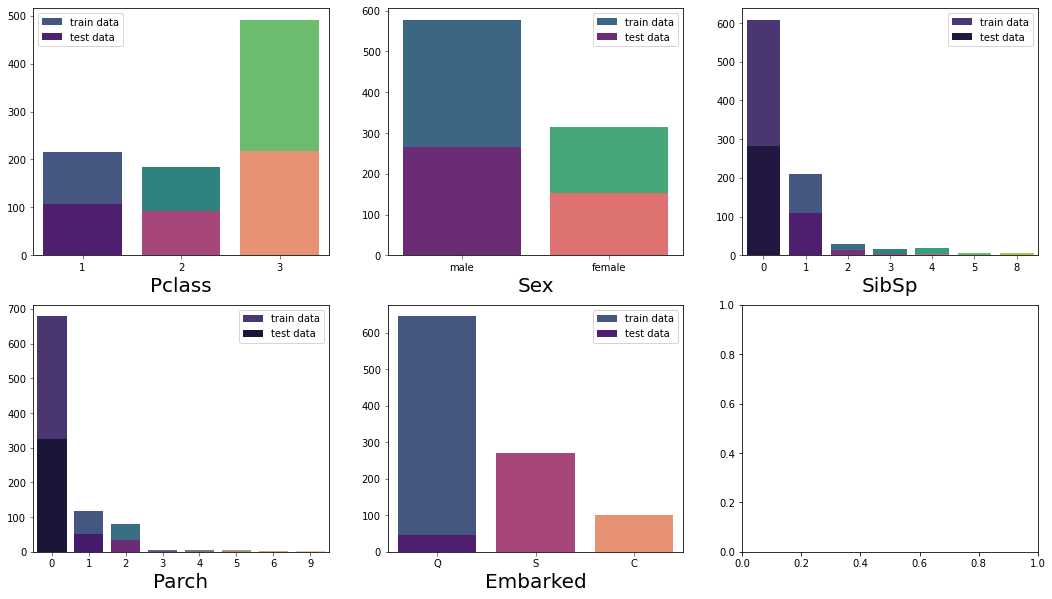

In [541]:
if len(cat_features) == 0:
    print('No categorical Features')
else:
    ncols=3
    nrows=2
    
    fig,axes=plt.subplots(nrows, ncols, figsize=(18,10))
    for r in range(nrows):
        for c in range(ncols):
            try:
                col=cat_features[r*ncols+c]
                sns.countplot(train[col], ax=axes[r,c], palette='viridis', label='train data')
                sns.countplot(test[col], ax=axes[r,c], palette='magma', label='test data')

                axes[r,c].legend()
                axes[r,c].set_ylabel('')
                axes[r,c].set_xlabel(col, fontsize=20)
                axes[r,c].tick_params(labelsize=10, width=.5)
                axes[r,c].yaxis.offsetText.set_fontsize(4)
                axes[r,c].xaxis.offsetText.set_fontsize(4)
            except:pass

    plt.show()
        

## Target 분포

In [542]:
target_df = pd.DataFrame(train[Target].value_counts()).reset_index()
target_df.columns=[Target,'count']

fig=px.bar(data_frame=target_df, x=Target, y='count')
fig.update_traces(marker_color=colors,
                 marker_line_color='rgb(0,0,0)',
                 marker_line_width=2)

fig.update_layout(title='Target Distribution', template='plotly_white', title_x=.5)

print(f'\033[94m Percentage of Survived = 0 : {target_df["count"][0]*100 / train.shape[0]:.2f}%')
print(f'\033[94m Percentage of Survived = 1 : {target_df["count"][1]*100 / train.shape[0]:.2f}%')

fig.show()

 Percentage of Survived = 0 : 61.62%
 Percentage of Survived = 1 : 38.38%


## 상관관계도 (Correlation Matrix)

In [543]:
fig=px.imshow(train.corr(), text_auto=True, aspect='auto', color_continuous_scale='viridis')
fig.show()

# 전처리

## 범주형 변수 인코딩

In [544]:
label_cols=['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Cabin']

def label_encoder(train,test, columns):
    for col in columns:
        train[col]=train[col].astype(str)
        test[col]=test[col].astype(str)
        train[col]=LabelEncoder().fit_transform(train[col])
        test[col]=LabelEncoder().fit_transform(test[col])
    return train, test

## 결측값 처리 방법 평가

In [558]:
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds=model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

## Imputing Missing Valued

In [546]:
# Cabin 앞자리 알파벳 추출
train['Cabin']=[i[0] if type(i)!=float else i for i in train['Cabin']]

# Cabin 변수 범주열에 추가
cat_features.append('Cabin')

# Cabin 변수 연속형 열에서 제거
cont_features=['Age', 'Fare']

In [547]:
imp_train=train.copy()
imp_test=test.copy()
# 범주형 인코딩
label_cols=[col for col in Features if train[col].nunique() < 10]
imp_train, imp_test = label_encoder(imp_train, imp_test, label_cols)

imp_train.drop(['Name','Ticket'], axis=1, inplace=True)
imp_test.drop(['Name','Ticket'], axis=1, inplace=True)

imputer_cols = ['Age']
imputer=SimpleImputer(strategy=Strategy)
imputer.fit(imp_train[imputer_cols])

imp_train[imputer_cols]=imputer.transform(imp_train[imputer_cols])
imp_test[imputer_cols]=imputer.transform(imp_test[imputer_cols])

imp_train['Embarked'].fillna('S',inplace=True)
imp_test['Embarked'].fillna('S',inplace=True)

imp_train['Cabin'].fillna('C', inplace=True)
imp_test['Cabin'].fillna('C', inplace=True)



In [568]:
X=imp_train.iloc[:,1:]
y=imp_train[Target]

X_train,X_valid, y_train, y_test=train_test_split(X,y,random_state=Random_state)

print("MAE From SimpleImputer")
print(score_dataset(X_train, X_valid, y_train, y_test))

MAE From SimpleImputer
0.26370239874724183


## Drop Missing Columns

In [549]:
drop_train=train.copy()
drop_test=test.copy()
label_cols=[col for col in Features if train[col].nunique() < 10]

# 범주형 인코딩
drop_train, drop_test=label_encoder(drop_train, drop_test, label_cols)

drop_train['Embarked'].fillna('S', inplace=True)
drop_test['Embarked'].fillna('S',inplace=True)

# 결측치 제거
train_drop=drop_train.drop(missing_cols, axis=1)
test_drop=drop_test.drop(missing_cols, axis=1)

In [559]:
X=train_drop.iloc[:,1:]
y=train[Target]

X_train,X_valid, y_train, y_test=train_test_split(X,y,random_state=Random_state)

print("MAE From Drop Columns")
print(score_dataset(X_train, X_valid, y_train, y_test))

MAE From Drop Columns
0.2746672919852526


위 결과에서 결측값을 포함한 열을 삭제하는 것보다 **SimpleImputer**로 대치해 모델링하는 것의 결과가 더 좋은 것을 볼 수 있다.

# Modeling

In [571]:
def modelings(train, test):
    model_train=train.copy()
    model_test=test.copy()
    

    
    X=model_train.drop(Target, axis=1)
    y=model_train[Target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=Random_state)
    
    # modeling
    clf = LazyClassifier(verbose=0,
                  ignore_warnings=True,
                  custom_metric=None,
                  predictions=False,
                  random_state=Random_state)
    
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
        
    # Accuracy vs Model 시각화
    
    line=px.line(data_frame=models, y=['Accuracy'], markers=True)
    
    line.update_xaxes(title='Model',rangeslider_visible=False)
    line.update_yaxes(title='Accuracy')
    line.update_traces(line_color='red')
    line.update_layout(showlegend=True, 
                      title={
                          'text':'Accuracy vs Models',
                          'y':0.94,
                          'x':0.5,
                          'xanchor':'center',
                          'yanchor':'top'
                      })
    
    line.show()
    
    return models[:15]

## 대치값 모델링
imp_train, imp_test

In [572]:
modelings(imp_train, imp_test)

 97%|█████████████████████████████████████████▌ | 28/29 [00:01<00:00, 20.05it/s]

[02:07:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 18.76it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.82,0.81,0.81,0.82,0.02
LinearSVC,0.81,0.79,0.79,0.81,0.05
Perceptron,0.79,0.79,0.79,0.79,0.02
CalibratedClassifierCV,0.80,0.79,0.79,0.80,0.16
LinearDiscriminantAnalysis,0.80,0.79,0.79,0.80,0.02
ExtraTreesClassifier,0.80,0.79,0.79,0.80,0.13
NuSVC,0.79,0.78,0.78,0.79,0.08
RandomForestClassifier,0.80,0.78,0.78,0.80,0.33
RidgeClassifierCV,0.79,0.78,0.78,0.79,0.01


## 열 삭제 모델링
drop_train, drop_test

In [573]:
modelings(drop_train, drop_test)

 90%|██████████████████████████████████████▌    | 26/29 [00:03<00:00,  6.24it/s]

[02:07:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|███████████████████████████████████████████| 29/29 [00:05<00:00,  5.45it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RidgeClassifierCV,0.84,0.83,0.83,0.84,0.10
LinearSVC,0.84,0.83,0.83,0.84,0.09
PassiveAggressiveClassifier,0.84,0.83,0.83,0.84,0.13
RidgeClassifier,0.84,0.83,0.83,0.84,0.05
CalibratedClassifierCV,0.84,0.82,0.82,0.84,0.12
LogisticRegression,0.83,0.82,0.82,0.83,0.09
DecisionTreeClassifier,0.83,0.81,0.81,0.83,0.07
Perceptron,0.82,0.81,0.81,0.82,0.05
SGDClassifier,0.82,0.80,0.80,0.82,0.05
